# HW 2: Clustering and Topic Models [100 points]

Name: Emmanuel Gama Ibarra

Andrew ID: egama

Collaborators (if none, say "none"; do *not* leave this blank): 

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). Data is provided in the `enron` data directory, with one file per email. The data set includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam. 

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the makeWordList function, construct a list of processed documents.

In [4]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [5]:
import spacy 
import glob
import pandas as pd
from operator import itemgetter 
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
plt.style.use("seaborn")
%config InlineBackend.figure_format = 'retina'
nlp = spacy.load("en")

list_files = glob.glob('./data/*.txt')

#Apply the function to all the emails 
proc_documents = [makeWordList(document) for document in list_files ]

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50, stop_words="english", max_df=.8)
X = vectorizer.fit_transform(proc_documents)

word_dict = {}
for word in vectorizer.vocabulary_:
    n = vectorizer.vocabulary_[word]
    word_dict[word]= n

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 50, stop_words = "english", max_df=.8)
X = vectorizer.fit_transform(proc_documents)

word_dict = {}
for word in vectorizer.vocabulary_:
    n=vectorizer.vocabulary_[word]
    word_dict[word] = n

### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix X using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [26]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm_fit = gmm.fit(X.toarray())
gmm_predict = gmm.predict(X.toarray())

for cluster in range(len(gmm_predict[:4])):
        print('Cluster {} contains {} emails'.format(cluster, (gmm_predict==cluster).sum(), "email"))

#print('Cluster 2 contains', (gmm_predict==1).sum(), 'emails')
#print('Cluster 3 contains', (gmm_predict==2).sum(), 'emails')

Cluster 0 contains 843 emails
Cluster 1 contains 365 emails
Cluster 2 contains 3963 emails
Cluster 3 contains 0 emails


In [32]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm_fited = gmm.fit(X.toarray())
gmm_predict = gmm.predict(X.toarray())
for cluster in range(3):
    print("cluster {} contains {} emails ".format(cluster, np.sum(gmm_predict==cluster)))

cluster 0 contains 3187 emails 
cluster 1 contains 1620 emails 
cluster 2 contains 364 emails 


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes four parameters:
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [33]:
def plot_spam_words_by_cluster(predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [92]:
#Create a list with the vobulary
vocabulary = vectorizer.vocabulary_
vocabulary_list = list(vocabulary)
vocabulary_list

['compensation',
 'analysis',
 'sally',
 'just',
 'fyi',
 'sent',
 'email',
 'telephone',
 'regards',
 'todd',
 'forwarded',
 'na',
 'enron',
 'bob',
 'hall',
 'brenda',
 'herod',
 'hou',
 'ect',
 'peggy',
 'steve',
 'jackson',
 'leslie',
 'reeves',
 'white',
 'scott',
 'james',
 'corp',
 'mary',
 'solmonson',
 'sheri',
 'thomas',
 'shona',
 'wilson',
 'brent',
 'price',
 'cc',
 'energy',
 'operations',
 'ena',
 'human',
 'resources',
 'attached',
 'know',
 'beck',
 'requested',
 'current',
 'pay',
 'staff',
 'purpose',
 'ensure',
 'department',
 'line',
 'competitive',
 'base',
 'bonus',
 'long',
 'term',
 'total',
 'process',
 'begin',
 'interviews',
 'data',
 'focus',
 'group',
 'opportunity',
 'address',
 'internal',
 'job',
 'establish',
 'agreed',
 'time',
 'meet',
 'discuss',
 'positions',
 'reflect',
 'responsibilities',
 'able',
 'percent',
 'contained',
 'non',
 'reviewed',
 'using',
 'approach',
 'help',
 'facilitate',
 'taken',
 'send',
 'meeting',
 'pre',
 'respective',
 '

In [34]:
vocabulary = vectorizer.vocabulary_
vocabulary_list = list(vocabulary)


In [55]:
spam_words = ["attention", 'opportunity', 'bonus']
ham_words = ['jerk', 'terrible', 'fuck']
spam_indices = [i for i in range(len(vocabulary_list)) if vocabulary_list[i] in spam_words ]
ham_indices = [i for i in range(len(vocabulary_list)) if vocabulary_list[i] in spam_words]


In [93]:
#Select the words and create the lists to append the indexes
spam_words = ["attention", 'opportunity', 'bonus']
ham_words = ['forward', 'questions', 'project']
spam_indices = []
ham_indices = []

for word in range(len(vocabulary_list)):
    if vocabulary_list[word] in spam_words:
        spam_indices.append(word)
    elif vocabulary_list[word] in ham_words:
        ham_indices.append(word)
#print(spam_indices)
#print(ham_indices)

In [36]:
range(len(vocabulary_list))

range(0, 1680)

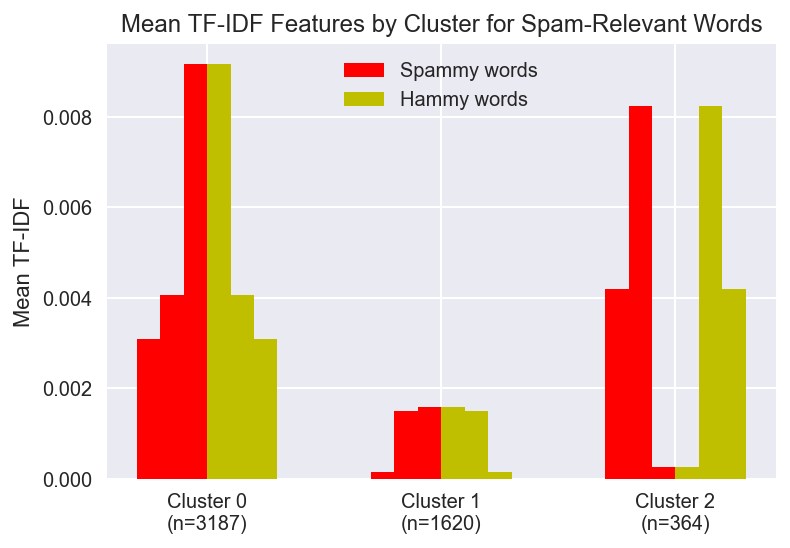

In [62]:
plot_spam_words_by_cluster(predicted=gmm_predict, n_clusters=3, spam_indices= spam_indices, ham_indices= ham_indices)

In [61]:
for c in range(3):
    print("cluster ", c)
    for i in range(3):
        print("spam", spam_words[i], X[gmm_predict == c][:,spam_indices[i]].todense().sum())
        print("good", ham_words[i], X[gmm_predict == c][:,ham_indices[i]].todense().sum())
        

cluster  0
spam attention 9.853008742498027
good jerk 9.853008742498027
spam opportunity 12.939422790142787
good terrible 12.939422790142787
spam bonus 29.17340055080244
good fuck 29.17340055080244
cluster  1
spam attention 0.2258627878816384
good jerk 0.2258627878816384
spam opportunity 2.4252628201471227
good terrible 2.4252628201471227
spam bonus 2.574818848489999
good fuck 2.574818848489999
cluster  2
spam attention 1.524844237848249
good jerk 1.524844237848249
spam opportunity 3.0001895415504953
good terrible 3.0001895415504953
spam bonus 0.09026103730624674
good fuck 0.09026103730624674


In [58]:
X.shape

(5171, 1680)

In [59]:
spam_indices

[55, 65, 321]

In [95]:
for c in range(3):
    print("cluster ", c)
    for i in range(3):
        print("spam", spam_words[i], X[gmm_predict == c][:,spam_indices[i]].todense().sum())
    for i in range(3):
        print("good words", ham_words[i], X[gmm_predict == c][:,ham_indices[i]].todense().sum())

cluster  0
spam attention 4.637049525849449
spam opportunity 8.332087646716015
spam bonus 1.464958518045193
good words forward 3.888918764737933
good words questions 40.720977024389626
good words project 0.11037288386740982
cluster  1
spam attention 5.441822004530217
spam opportunity 7.225783475311485
spam bonus 30.283260881247248
good words forward 1.1506295768600256
good words questions 4.508440849393806
good words project 6.846047642168187
cluster  2
spam attention 1.524844237848249
spam opportunity 2.807004029812905
spam bonus 0.09026103730624674
good words forward 0.43422663179226356
good words questions 5.0402750804592955
good words project 0.28035495647910896


***First QUestion do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)?**
The results of the clustering excercise is telling us that the model is able to idenfity HAMMY emails in the first cluster. The second cluster seem to be mostly SPAMMY words. The last cluster seem to be even out between spammy and hammy words.   


**Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

***ANSWER WRITTEN*** :
Changing the number of clusters seems to change the optimal answer. For example, when having 5 cluster, one of them have very few alements, which would say that 5 is not optimal. On the other hand 2 cluster does not idenfiy one cluster that is formed just by hammy or spam words. With these results I would say that 3 is the optimal number of clusters because it lets me have one cluster with just spam email. 

In [96]:
gmm2 = GaussianMixture(n_components=5)
gmm_fit2 = gmm2.fit(X.toarray())
gmm_predict2 = gmm2.predict(X.toarray())

for cluster in range(len(gmm_predict2[:5])):
        print('Cluster {} contains {} emails'.format(cluster, (gmm_predict2==cluster).sum(), "email"))


Cluster 0 contains 1177 emails
Cluster 1 contains 2996 emails
Cluster 2 contains 455 emails
Cluster 3 contains 325 emails
Cluster 4 contains 218 emails


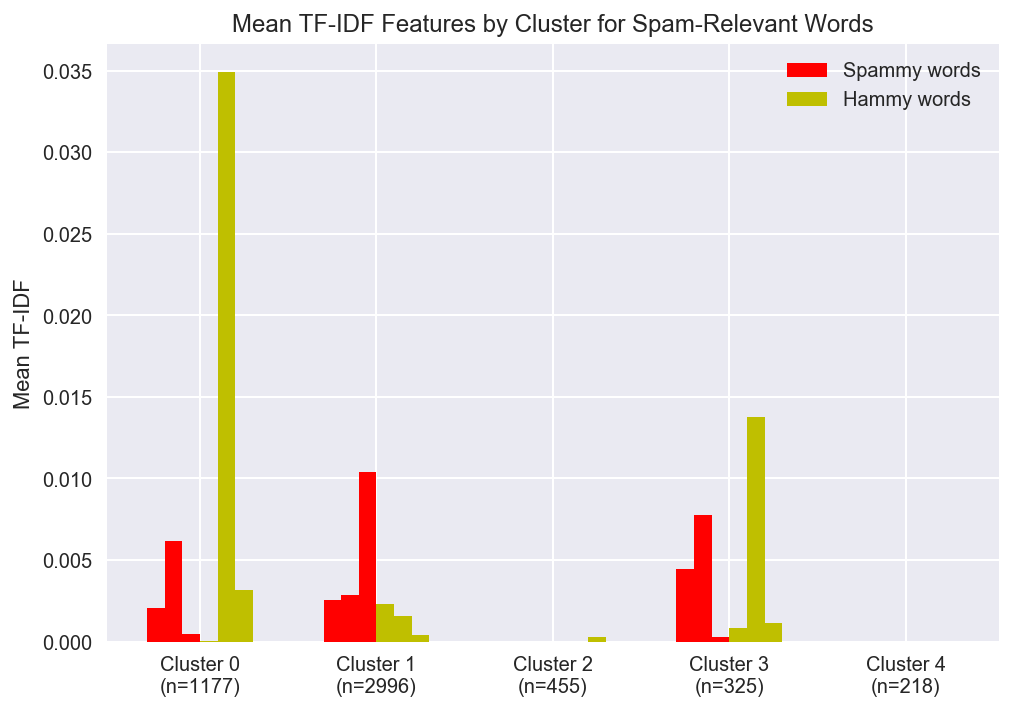

In [97]:
plot_spam_words_by_cluster(predicted=gmm_predict2, n_clusters=5, spam_indices= spam_indices, ham_indices= ham_indices)

In [100]:
gmm2 = GaussianMixture(n_components=2)
gmm_fit2 = gmm2.fit(X.toarray())
gmm_predict2 = gmm2.predict(X.toarray())

for cluster in range(len(gmm_predict2[:2])):
        print('Cluster {} contains {} emails'.format(cluster, (gmm_predict2==cluster).sum(), "email"))


Cluster 0 contains 684 emails
Cluster 1 contains 4487 emails


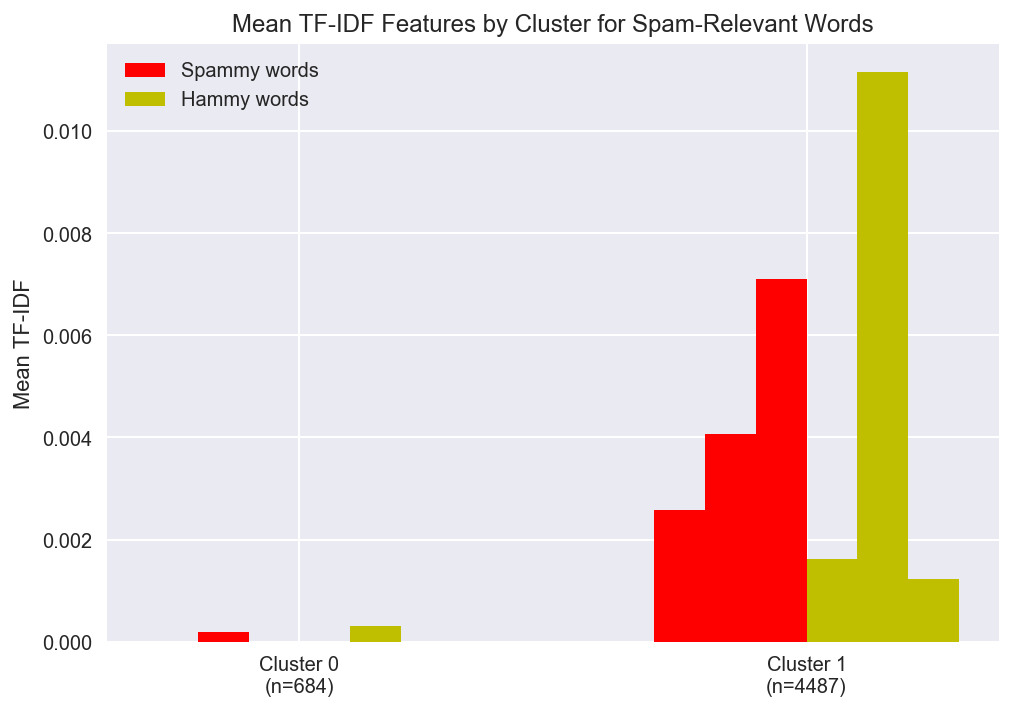

In [101]:
plot_spam_words_by_cluster(predicted=gmm_predict2, n_clusters=2, spam_indices= spam_indices, ham_indices= ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [103]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [104]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM
#print(len(app_names))
#print(len(app_ratings))
#print(len(df_perms))
#print(X.shape)

### Part C: Downweight "stop-words" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [105]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
x_transformed = transformer.fit_transform(X)
#print(x_transformed.toarray())
#x_transformed.shape

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [106]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, max_iter=10, n_jobs=-1, learning_method= "online", random_state= 0)
X_latent = lda.fit_transform(x_transformed.toarray())

import numpy as np
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

#lda.components_
#topic_word_distributions[3,:].sum()

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   ***Answer***
   * Topic 6 gathers apps that are interested in in your location
   * Topic 9 gathers apps that are interested in your personal information
   * topic 1 gathers apps that are interested in having access to your phone physical controlers like networks and harware"

In [107]:
#lda.components_.shape
import numpy as np
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

num_top_words = 10

import numpy as np
for topic_idx in range(10):
    print('[Topic %d]' % topic_idx)
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print('%s: %f' % (permission_columns[word_idx], topic_word_distributions[topic_idx, word_idx]))
    print()

[Topic 0]
Phone calls : read phone state and identity (D): 0.544596
Network communication : view network state (S): 0.229301
Network communication : full Internet access (D): 0.224427
Default : force application to close (S): 0.000449
Storage : modify/delete USB storage contents modify/delete SD card contents (D): 0.000007
System tools : prevent device from sleeping (D): 0.000007
Development tools : make all background applications close (D): 0.000007
System tools : retrieve running applications (D): 0.000007
Your location : fine (GPS) location (D): 0.000007
Your location : coarse (network-based) location (D): 0.000007

[Topic 1]
Hardware controls : control vibrator (S): 0.698085
Network communication : full Internet access (D): 0.175236
Network communication : view network state (S): 0.097760
System tools : allow Wi-Fi Multicast reception (D): 0.017585
Hardware controls : test hardware (S): 0.008893
Default : run in factory test mode (S): 0.000797
Default : modify/delete USB storage c

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [108]:
#X_latent.shape
#X_latent[5, :].sum()
sorted_columns = np.argsort(X_latent[:, 0])[::-1]
high_ranking_sorted = [i for i in sorted_columns if app_ratings[i]>100000]

for topic in range(10):
    sorted_columns = np.argsort(X_latent[:, topic])[::-1]
    high_ranking_sorted = [i for i in sorted_columns if app_ratings[i]>100000]
    print("[topic] ", topic)
    for rank in range(3):
        print(" App {} in this topic is {}".format(rank, app_names[high_ranking_sorted[rank]]))  

[topic]  0
 App 0 in this topic is Blast Monkeys
 App 1 in this topic is World Newspapers
 App 2 in this topic is Paradise Island
[topic]  1
 App 0 in this topic is Drag Racing
 App 1 in this topic is Bubble Blast 2
 App 2 in this topic is Mouse Trap
[topic]  2
 App 0 in this topic is Angry Birds Seasons
 App 1 in this topic is Yoo Ninja! Free
 App 2 in this topic is Adobe Reader
[topic]  3
 App 0 in this topic is Netflix
 App 1 in this topic is Advanced Task Killer
 App 2 in this topic is Zynga Poker
[topic]  4
 App 0 in this topic is Restaurant Story???
 App 1 in this topic is Restaurant Story™
 App 2 in this topic is Gmail
[topic]  5
 App 0 in this topic is SpeechSynthesis Data Installer
 App 1 in this topic is Racing Moto
 App 2 in this topic is My Country
[topic]  6
 App 0 in this topic is Tiny Flashlight + LED
 App 1 in this topic is Toss It
 App 2 in this topic is GasBuddy
[topic]  7
 App 0 in this topic is Racing Moto
 App 1 in this topic is Angry Birds Rio
 App 2 in this topic

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [112]:
%%time
sample =np.random.permutation(X_latent)[:10000]


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state= 0, perplexity= 5, angle=0.99, init="pca", learning_rate=100)
tsne_app = tsne.fit_transform(sample)

highest_prob = np.argsort(-sample)
highest_prob_per_app = highest_prob[:,0]
highest_prob_per_app[:10]


CPU times: user 2min 2s, sys: 17.3 s, total: 2min 19s
Wall time: 1min 10s


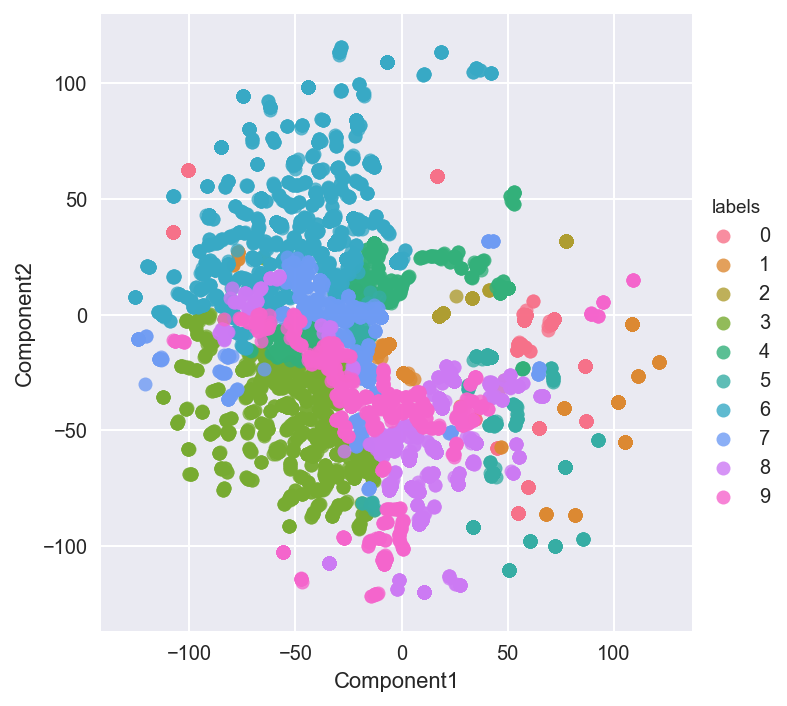

In [117]:
d = pd.DataFrame(tsne_app, columns = ['Component1','Component2'])
d['labels'] = highest_prob_per_app
facet = sns.lmplot(data=d, x='Component1', y='Component2', hue='labels', 
                   fit_reg=False, legend=True, legend_out=True)

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://goo.gl/forms/qi1acwKwxSfNJfjt1
***I DID ANSWER THE QUESTIONARDE